# Importing the libraries

In [21]:
import os
import shutil
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D, Add, BatchNormalization, LeakyReLU, Reshape, Flatten, Dense, Add
from keras.layers.convolutional import Deconvolution2D
from keras.layers import merge
from keras.optimizers import Adam
import numpy as np
from random import sample 
from keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
from warnings import filterwarnings
filterwarnings('ignore')

Defining a function to sort the image filenames so we can load images in order.

In [22]:
import re
import glob
import PIL
from PIL import Image
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Loading the data

In [23]:
filelist_trainx = sorted(glob.glob('../input/*/trainx/*.jpg'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('../input/*/trainy/*.jpg'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

filelist_testx = sorted(glob.glob('../input/*/testx/*.jpg'), key=numericalSort)
X_test = np.array([np.array(Image.open(fname)) for fname in filelist_testx])

filelist_testy = sorted(glob.glob('../input/*/testy/*.jpg'), key=numericalSort)
Y_test = np.array([np.array(Image.open(fname)) for fname in filelist_testy])

filelist_valx = sorted(glob.glob('../input/*/validationx/*.jpg'), key=numericalSort)
X_val = np.array([np.array(Image.open(fname)) for fname in filelist_valx])

filelist_valy = sorted(glob.glob('../input/*/validationy/*.jpg'), key=numericalSort)
Y_val = np.array([np.array(Image.open(fname)) for fname in filelist_valy])


In [24]:
(x_train, y_train), (x_test, y_test), (x_val, y_val) = (X_train, Y_train), (X_test, Y_test), (X_val, Y_val)

# AutoEncoder with skip connection

In [25]:
input_img = Input(shape = (192, 256, 3))
conv1 = Conv2D(32, (3, 3), strides = (2,2), activation='relu', padding='same')(input_img) #96 x 128 x 32
conv2 = Conv2D(32, (3, 3), strides = (2,2), activation='relu', padding='same')(conv1) #48 x 64 x 32
conv3 = Conv2D(64, (3, 3),strides = (2,2), activation='relu', padding='same')(conv2) #24 x 32 x 64
conv4 = Conv2D(64, (3, 3),strides = (2,2), activation='relu', padding='same')(conv3) # 12 x 16 x 64

deconv1 = Deconvolution2D(64, (3,3), strides = (2,2), activation = 'relu', padding='same')(conv4) #24 X 32 X 64
deconv2 = Deconvolution2D(32, (3,3), strides = (2,2), activation = 'relu', padding='same')(deconv1) #48 X 32 X 64
level1 = Add()([deconv2, conv2])  #skip connection

deconv3 = Deconvolution2D(32, (3,3), strides = (2,2), activation = 'relu', padding='same')(level1) # 96 X 128 X 32
level2 = Add() ([deconv3, conv1]) #skip connection
deconv4 = Deconvolution2D(32, (3,3), strides = (2,2), activation = 'relu', padding='same')(level2) # 192 X 128 X 32


decoded = Conv2D(3, 5, 5, activation='linear', border_mode='same')(deconv4)


encoder = Model(input_img,decoded)
encoder.compile(optimizer='adam', loss='mse')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 96, 128, 32)  896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 48, 64, 32)   9248        conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 24, 32, 64)   18496       conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_14 

# Train

In [26]:
batch_size = 128
epochs = 50
encoder.fit(x_train, x_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_val, x_val))

Train on 2000 samples, validate on 150 samples
Epoch 1/50
2000/2000 [==============================] - 8s 4ms/step - loss: 9594.6384 - val_loss: 651.5939
Epoch 2/50
2000/2000 [==============================] - 8s 4ms/step - loss: 790.9016 - val_loss: 524.8938
Epoch 3/50
2000/2000 [==============================] - 7s 4ms/step - loss: 488.3370 - val_loss: 435.3970
Epoch 4/50
2000/2000 [==============================] - 7s 4ms/step - loss: 422.3754 - val_loss: 379.0530
Epoch 5/50
2000/2000 [==============================] - 8s 4ms/step - loss: 367.2819 - val_loss: 325.3431
Epoch 6/50
2000/2000 [==============================] - 7s 4ms/step - loss: 288.2712 - val_loss: 244.2150
Epoch 7/50
2000/2000 [==============================] - 7s 4ms/step - loss: 198.1754 - val_loss: 157.6243
Epoch 8/50
2000/2000 [==============================] - 7s 4ms/step - loss: 121.7421 - val_loss: 105.0844
Epoch 9/50
2000/2000 [==============================] - 8s 4ms/step - loss: 83.2243 - val_loss: 80.5973


# Prediction

In [27]:
pred = encoder.predict(x_test)
pred.shape

(600, 192, 256, 3)

# Visualize Results

Test Images


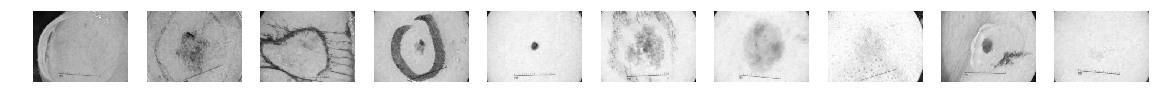

Reconstruction of Test Images


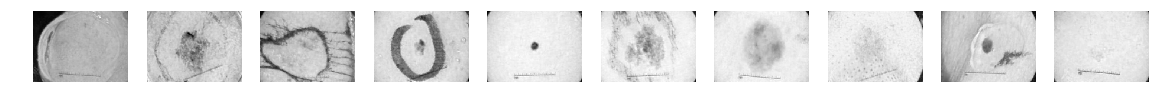

In [33]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
    plt.axis('off')
plt.show()